In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline

import sys
sys.version

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


'3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]'

In [12]:
setup = {
        "T9000":{"commissions":3, #元一手
                 "margin": 0.02,
                 "unit": 10000,
                 "bpv": 1},

        "j9000":{"commissions":0.00006, # 0.6%%
                 "margin": 0.05,
                 "unit": 100,
                 "bpv": 1},

        "au000":{"commissions":10, #元一手
                 "margin": 0.07,
                 "unit": 1000,
                 "bpv": 1},    

        "IC000":{"commissions":0.000023, #0.23%%
                 "margin": 0.08,
                 "unit": 1,
                 "bpv": 200},

        "l9000":{"commissions":2, #元一手
                 "margin": 0.05,
                 "unit": 5,
                 "bpv": 1},

        "m9000":{"commissions":0.00006, # 0.6%%
                 "margin": 0.05,
                 "unit": 10,
                 "bpv": 1},

        "OI000":{"commissions":2, #元一手
                 "margin": 0.05,
                 "unit": 10,
                 "bpv": 1},
                    }

In [15]:
# calculate lots手数:
# Lots[i] = IntPart(capital/(Data[i].Close * Data[i].BigPointValue * Data[i].ContractUnit * Data[i].MarginRatio));

def calc_lots(ticker_capital, price, bpv, unit, margin):
    # 一手保证金要求：
    margin_per_lot = price*bpv*unit*margin
    # 一手价值：
    value_per_lot = price*bpv*unit
    # 计算使用杠杆的手数：
    margin_lots = int(ticker_capital/(margin_per_lot))
    # 计算不使用杠杆的手数
    value_lots = int(ticker_capital/value_per_lot)

    return margin_per_lot, value_per_lot, margin_lots, value_lots

In [16]:
calc_lots(100000, 8580, setup['l9000']['bpv'], setup['l9000']['unit'], setup['l9000']['margin'])

(2145.0, 42900, 46, 2)

In [17]:
def portfolio_equity():
    pass

In [9]:
def preprocess_df(location, file):
    df = pd.read_csv(location+file, engine="python", header=None)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    return df

def preprocess_df_multiplies(file):
    df = pd.read_csv(file, engine="python", header=None)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    return df

def get_indicators(data, n, indicator):
    
    ###### Step 1: Calculate necessary time series ######
    up, dw = data['close'].diff(), -data['close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    # default set to be 12-period ema as the fast line, 26 as the slow line:
    macd = data['close'].ewm(12).mean() - data['close'].ewm(26).mean()
    # default set to be 9-period ema of the macd
    macd_signal = macd.ewm(9).mean()
    
    ###### Step 2: Create dataframe and fill with technical indicators: ######
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'momentum', 'rsi', 'macd'])
#     indicators['date'] = data['date']
    indicators['sma'] = data['close'].rolling(n).mean()
    indicators['ema'] = data['close'].ewm(n).mean()
    indicators['momentum'] = data['close'] - data['close'].shift(n)
    indicators['rsi'] = 100 - 100 / (1 + up.rolling(n).mean() / dw.rolling(n).mean())
    indicators['macd'] = macd - macd_signal
    indicators.index = data['date']
    return indicators[[indicator]]

def get_data(df, n):
    # technical indicators
    sma = get_indicators(df, n, 'sma')
    ema = get_indicators(df, n, 'ema')
    momentum = get_indicators(df, n, 'momentum')
    rsi = get_indicators(df, n, 'rsi')
    macd = get_indicators(df, n, 'macd')
    tech_ind = pd.concat([sma, ema, momentum, rsi, macd], axis = 1)
    df.index = df['date']
    close = df['close']
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'
    master_df = pd.concat([tech_ind, close, target], axis=1)
    return master_df

def rebalance(unbalanced_data, rblnc_rs):
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    # Separate majority and minority classes
    if unbalanced_data.target.value_counts()[0]>unbalanced_data.target.value_counts()[1]:
        print ("majority:0, length: {}; minority:1, length: {}".format(unbalanced_data.target.value_counts()[0],unbalanced_data.target.value_counts()[1]))
        data_minority = unbalanced_data[unbalanced_data.target==1] 
        data_majority = unbalanced_data[unbalanced_data.target==0] 
    else:
        print ("majority:1, length: {}; minority:0, length: {}".format(unbalanced_data.target.value_counts()[1],unbalanced_data.target.value_counts()[0]))
        data_minority = unbalanced_data[unbalanced_data.target==0] 
        data_majority = unbalanced_data[unbalanced_data.target==1] 
    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=rblnc_rs)
    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    data_upsampled.sort_index(inplace=True)
    # Display new class counts
    data_upsampled.target.value_counts()
    return data_upsampled

def normalize(x):
    scaler = StandardScaler()
    # 公式为：(X-mean)/std  计算时对每个属性/每列分别进行。
    # 将数据按期属性（按列进行）减去其均值，并除以其方差。得到的结果是，对于每个属性/每列来说所有数据都聚集在0附近，方差为1。
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    return x_norm

def scores(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    
    
def train_test_validate(master_df, train_start, train_end, test_size, tts_rs, rblnc_rs, plot=True): 
    # train_start example: '2011-01-01'
    # test_size defaults as 1/6, 
    # test_size: parameter
    
    data = master_df.copy()
    data.index = pd.to_datetime(data.index)
    if plot == True:
        print ("Plotting data's close price series")
        ax = data[['close']].plot(figsize=(20, 5))
        ax.set_ylabel("Price ($)")
        ax.set_xlabel("Time")
        plt.show()
    else:
        pass
    data_train = data[train_start : train_end]
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    data_train = rebalance(data_train, rblnc_rs).dropna()
    # y as the label target 
    y = data_train.target
    # X as the dataframe with their values to be normalized
    X = data_train.drop('target', axis=1)
    X = normalize(X)
    
    data_val = data[train_end:]
    data_val.dropna(inplace=True)
    # y_val as the label target in the validation period
    y_val = data_val.target
    # X_val as the dataframe with their values to be normalized in the validation period
    X_val = data_val.drop('target', axis=1)
    # normalize X_val dataframe
    X_val = normalize(X_val)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = tts_rs)
    print ("-----------------------------------------------")
    print ("X length: ", len(X))
    print ("X_val length: ", len(X_val))
    print ("X_train length: ", len(X_train))
    print ("X_test length: ", len(X_test))
    print ("-----------------------------------------------")
    print ("y length: ", len(y))
    print ("y_val length: ", len(y_val))
    print ("y_train length:", len(y_train))
    print ("y_test length:", len(y_test))
    print ("-----------------------------------------------")
    # Outputs of this function are 8 variables from above.
    return data, X, X_val, X_train, X_test, y, y_val, y_train, y_test
    
    
def optimize_model_paras(X_train, y_train, X_test, y_test):
    # first take a look at the default model's results:
    model = RandomForestClassifier(random_state=5)
    print ("Training default model...")
    model.fit(X_train, y_train)
    print ("Default model's scores:")
    scores(model, X_test, y_test)
    # set up parameters to be optimized
    grid_data =   {'n_estimators': [10, 50, 100],
                   'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 10, 50, 100],
                   'min_samples_split': [2, 5, 10],
                   'random_state': [1]}
    grid = GridSearchCV(model, grid_data, scoring='f1').fit(X_train, y_train)
    print ("-----------------------------------------------")
    print ("Model's best parameters: ")
    print(grid.best_params_)
    model = grid.best_estimator_
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Performance of the train_test datasets: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    print ("Optimized Model from the train_test dataset: ", model)
    
    # Validate optimized model:
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    
    optimized_model = model
    return optimized_model

def train_test_backtest(data, optimized_model, X, y, X_train, y_train, start_capital):
    rf_model = optimized_model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("train_test datasets performance: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['close'].diff()
    data_returns = data_returns[X.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum() + start_capital
    equity = model_returns.sum()
    start_close = data["close"][X.index[0]]
    performance = equity / start_close * 100
    
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns (￥)")
#     ax.set_xlabel("Time")
#     plt.show()

#     ax = model_cum.plot(figsize=(15, 8))
#     ax.set_ylabel("Cummulative returns (￥)")
#     ax.set_xlabel("Time")
#     plt.show()
    return model_cum, equity, performance, mask, y_pred, data_returns


# Trading system: testing real performance:
def validate_backtest(data, optimized_model, X_val, y_val, X_train, y_train, start_capital):
    rf_model = optimized_model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("validation datasets performance: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['close'].diff()
    data_returns = data_returns[X_val.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum()+start_capital
    equity = model_returns.sum()
    start_close = data["close"][X_val.index[0]]
    performance = equity / start_close * 100
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns ($)")
#     ax.set_xlabel("Time")
#     plt.show()
    ax = model_cum.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns ($)")
    ax.set_xlabel("Time")
    plt.show()
#     print (pd.DataFrame(model_cum)) # 对了
    return model_cum, equity, performance, mask, y_pred, data_returns, acc

# Create signal file that is to be imported to TB:
def create_TB_signal_df(df, X_val, y_pred, y_val, mask, data_returns, folder, exported_file, start_capital):
    print ("Processing signal dataframe...")
    master_pred_df = X_val.copy()
    master_pred_df['y_pred'] = y_pred
    master_pred_df['y_val'] = y_val
    master_pred_df['mask'] = mask
    master_pred_df['data_returns'] = data_returns
    master_pred_df['model_returns'] = mask * data_returns
    master_pred_df['cum_sum'] = master_pred_df['model_returns'].cumsum()
    master_pred_df['portfolio_equity'] = master_pred_df['cum_sum']+start_capital
    master_pred_df_dt = master_pred_df.copy()
    master_pred_df_dt.reset_index(inplace = True)
    
    print ("Processing original OHLCV dataframe...")
    df_dt = df.copy()
    del df_dt['date']
    df_dt.reset_index(inplace= True)
    df_dt['date'] = pd.to_datetime(df_dt['date'])

    print ("Merging signal dataframe and OHLCV dataframe...")
    master_pred_df_dt = master_pred_df_dt[['date', 'mask']]
    merged = df_dt[['date', 'open', 'high', 'low', 'close']].merge(master_pred_df_dt, on = 'date')
    merged.columns = ['date', 'open', 'high', 'low', 'close', 'signals']
    
    print ("Exporting final signal file...")
    merged.to_csv(folder + exported_file, index = False, header = False)
    print ("All done!")
    
    return merged, master_pred_df

In [10]:
def RF_rs_loop_AIO_multiplies(rblnc_rs, tts_rs, RFC_rs, n_e, m_d, m_s_s, start_capital):

    # Part 1:
    df = preprocess_df_multiplies(file)

    # Part 2:
    master_df = get_data(df, n)

    # Part 3:
    data, X, X_val, X_train, X_test, y, y_val, y_train, y_test = train_test_validate(master_df, '2011-01-01','2017-01-01', test_size, tts_rs, rblnc_rs, False)

    # Part 4.1: if we already have all optimized parameters we just run this step: 
    optmzd_model = RandomForestClassifier(
                max_depth=m_d,
                min_samples_split=m_s_s,
                n_estimators=n_e,
                random_state=RFC_rs
                )

    # Part 5: See in-sample backtest
    model_cum, equity, performance, mask, y_pred, data_returns = train_test_backtest(data, optmzd_model, X, y, X_train, y_train, start_capital)

    # Part 6: See out-of-sample backtest
    model_cum_, equity_, performance_, mask_, y_pred_, data_returns_, acc_ = validate_backtest(data, optmzd_model, X_val, y_val, X_train, y_train, start_capital)
#     print (pd.DataFrame(model_cum_))  # 已解决
    return model_cum_, y_pred_, acc_, df, X_val, y_val, mask_, data_returns_

=====================================Start backtesting au000=====================================
majority:0, length: 2319; minority:1, length: 2255


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  4638
X_val length:  1923
X_train length:  3865
X_test length:  773
-----------------------------------------------
y length:  4638
y_val length:  1923
y_train length: 3865
y_test length: 773
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 92.35 %
F1 Score: 0.9232
Area Under ROC Curve Score: 0.9235
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 49.45 %
F1 Score: 0.4282
Area Under ROC Curve Score: 0.4908
----------------------------------------------------


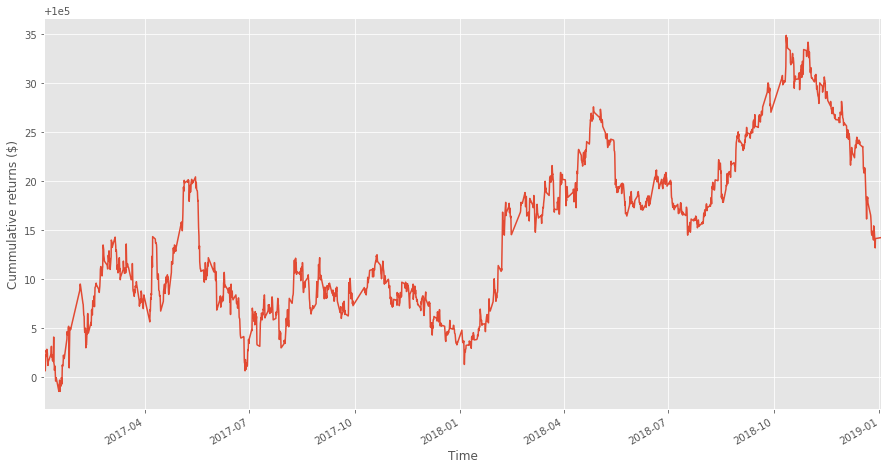

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting IC000=====================================
majority:1, length: 436; minority:0, length: 407


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  863
X_val length:  998
X_train length:  719
X_test length:  144
-----------------------------------------------
y length:  863
y_val length:  998
y_train length: 719
y_test length: 144
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 91.77 %
F1 Score: 0.9148
Area Under ROC Curve Score: 0.9177
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.90 %
F1 Score: 0.5110
Area Under ROC Curve Score: 0.5103
----------------------------------------------------


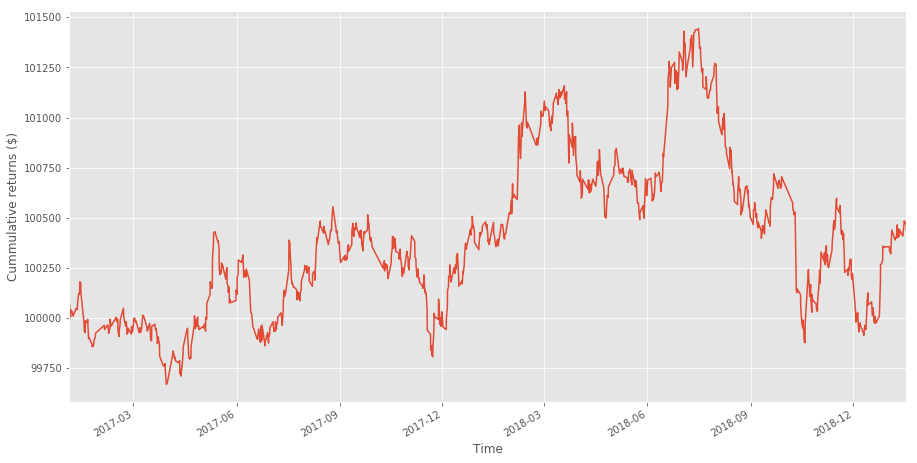

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting j9000=====================================
majority:0, length: 1949; minority:1, length: 1627


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  3891
X_val length:  1448
X_train length:  3242
X_test length:  649
-----------------------------------------------
y length:  3891
y_val length:  1448
y_train length: 3242
y_test length: 649
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 93.73 %
F1 Score: 0.9372
Area Under ROC Curve Score: 0.9373
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.28 %
F1 Score: 0.4546
Area Under ROC Curve Score: 0.5250
----------------------------------------------------


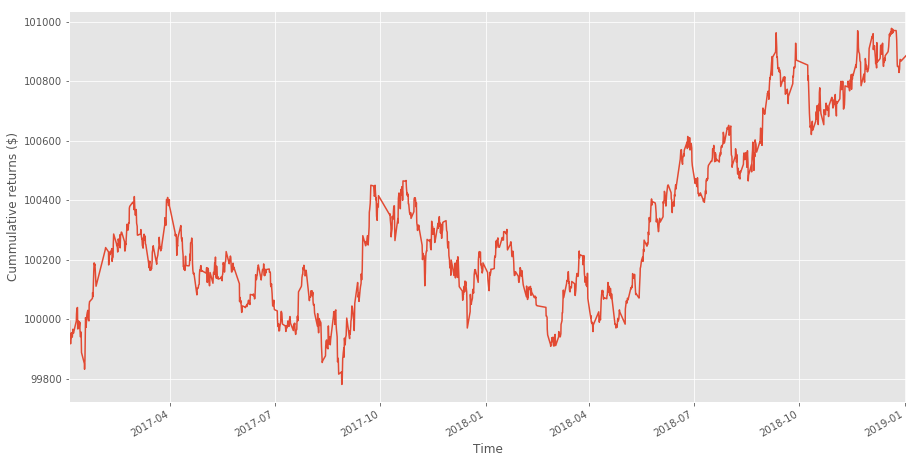

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting l9000=====================================
majority:0, length: 1498; minority:1, length: 1418


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  2996
X_val length:  999
X_train length:  2496
X_test length:  500
-----------------------------------------------
y length:  2996
y_val length:  999
y_train length: 2496
y_test length: 500
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 93.62 %
F1 Score: 0.9357
Area Under ROC Curve Score: 0.9362
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.85 %
F1 Score: 0.4015
Area Under ROC Curve Score: 0.5217
----------------------------------------------------


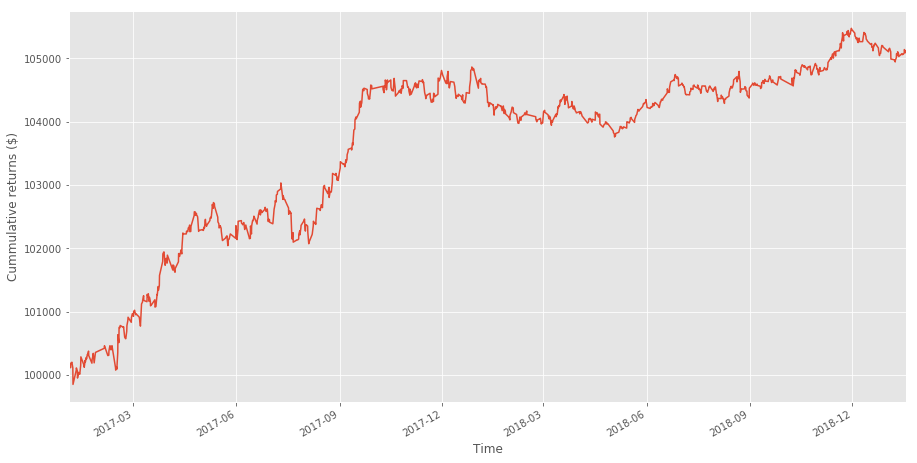

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting m9000=====================================
majority:0, length: 1805; minority:1, length: 1668


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  3610
X_val length:  1484
X_train length:  3008
X_test length:  602
-----------------------------------------------
y length:  3610
y_val length:  1484
y_train length: 3008
y_test length: 602
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 93.30 %
F1 Score: 0.9332
Area Under ROC Curve Score: 0.9330
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 51.95 %
F1 Score: 0.4611
Area Under ROC Curve Score: 0.5156
----------------------------------------------------


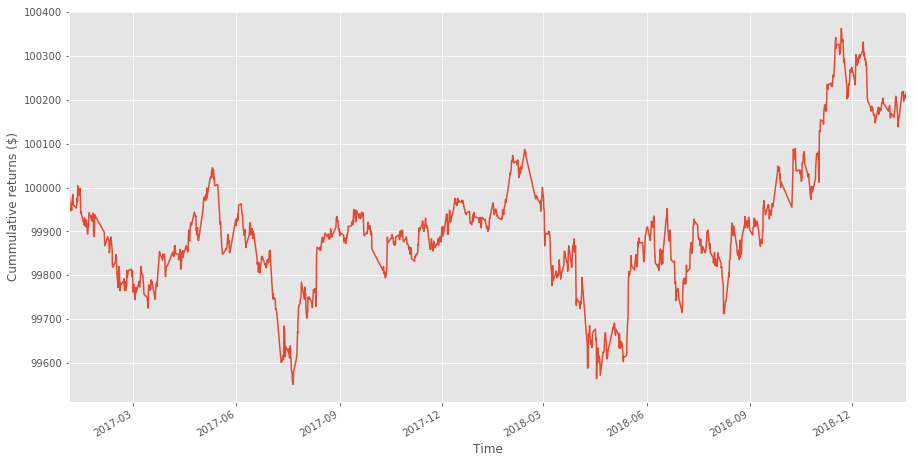

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting OI000=====================================
majority:0, length: 1274; minority:1, length: 1121
-----------------------------------------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



X length:  2541
X_val length:  1484
X_train length:  2117
X_test length:  424
-----------------------------------------------
y length:  2541
y_val length:  1484
y_train length: 2117
y_test length: 424
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 93.43 %
F1 Score: 0.9342
Area Under ROC Curve Score: 0.9343
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 53.84 %
F1 Score: 0.4268
Area Under ROC Curve Score: 0.5325
----------------------------------------------------


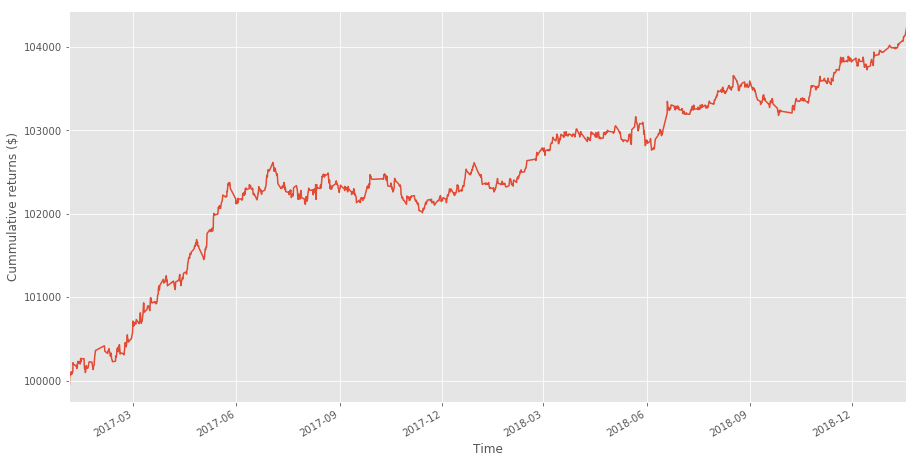

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
=====================================Start backtesting T9000=====================================
majority:1, length: 440; minority:0, length: 438
-----------------------------------------------
X length:  869
X_val length:  999
X_train length:  724
X_test length:  145
-----------------------------------------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



y length:  869
y_val length:  999
y_train length: 724
y_test length: 145
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 93.90 %
F1 Score: 0.9396
Area Under ROC Curve Score: 0.9390
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.35 %
F1 Score: 0.5303
Area Under ROC Curve Score: 0.5036
----------------------------------------------------


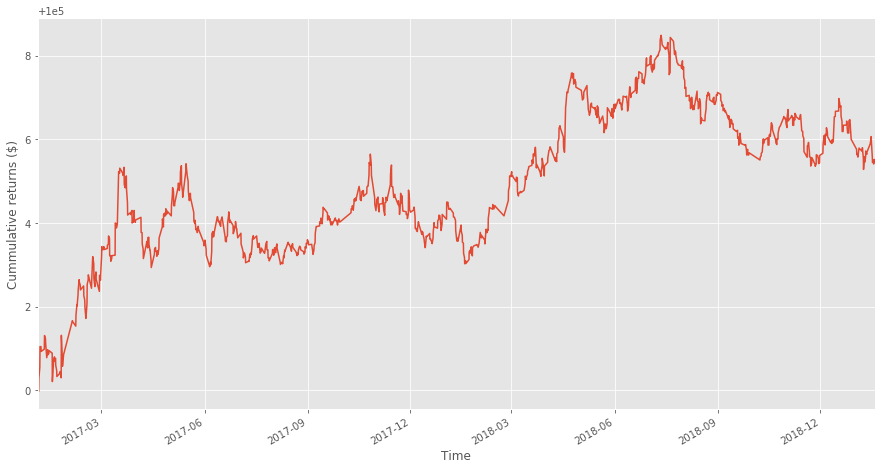

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
Exporting final signal file...
All done!
   RFC_rs  accuracy  backtest commodity  max_depth  min_samples_split  \
0       5  0.494540         1     au000         30                  2   
1       5  0.509018         2     IC000         30                  2   
2       5  0.522790         3     j9000         30                  2   
3       5  0.528529         4     l9000         30                  2   
4       5  0.519542         5     m9000         30                  2   
5       5  0.538410         6     OI000         30                  2   
6       5  0.503504         7     T9000         30                  2   

   n_estimators  rblnc_rs    sharpe  trades  tts_rs  
0            10         5  0.162058     579       5  
1            10         5  0.119855    

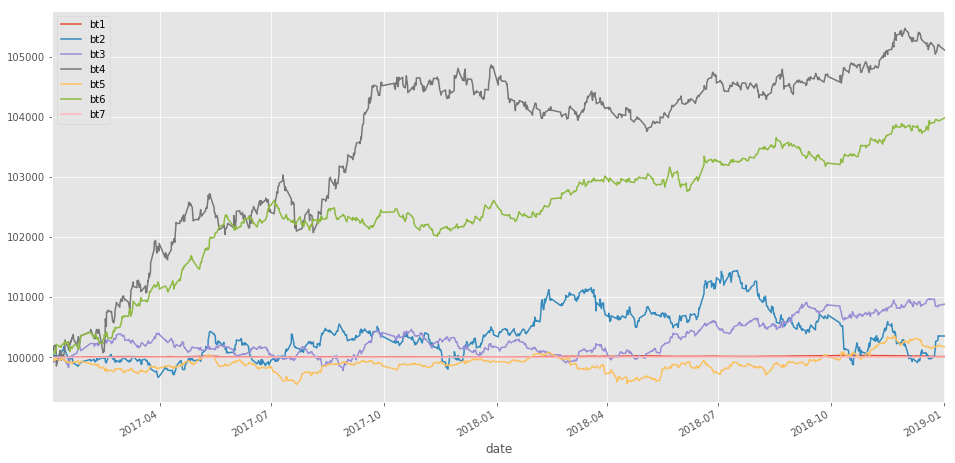

In [11]:
import glob

location = glob.glob("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/*.csv")
folder = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data/testing_4h_signals/"

backtest_records = {'commodity':[],
                    'backtest':[],
                    'n_estimators':[],
                    'max_depth':[],
                    'min_samples_split':[],
                    'rblnc_rs':[],
                    'tts_rs':[],
                    'RFC_rs':[],
                    'sharpe':[],
                    'trades':[],
                    'accuracy':[]}

n = 10
test_size = 1/6

# Main parameters are all here:
rblnc_rs = [5]
tts_rs = [5]
RFC_rs = [5]
n_estimators = [10]
max_depth = [30]
min_samples_split = [2]

# n_estimators = [10, 50, 100]
# max_depth = [100]
# min_samples_split = [10]

commodities = location

start_capital = 100000
# for daily strategies: trade_freq = 1, 
# for hourly strategies: trade_freq = 
trade_freq = 1

backtest_num = 0
backtest_curves = pd.DataFrame([])
total_paras_sets = len(rblnc_rs)*len(tts_rs)*len(RFC_rs)*len(n_estimators)*len(max_depth)*len(min_samples_split)
total_backtests = len(rblnc_rs)*len(tts_rs)*len(RFC_rs)*len(n_estimators)*len(max_depth)*len(min_samples_split)*len(commodities)
# 参数一：
for rs_1 in rblnc_rs:
    # 参数二：
    for rs_2 in tts_rs:
        # 参数三：
        for rs_3 in RFC_rs:
            # 参数四：
            for n_e in n_estimators:
                # 参数五：
                for m_d in max_depth:
                    # 参数六：
                    for m_s_s in min_samples_split:
                        # Loop 品种：
                        for file in location:
                            ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
                            print ("=====================================Start backtesting {}=====================================".format(ticker))
                            model_cum_, y_pred_, acc_, df, X_val, y_val, mask_, data_returns_ = RF_rs_loop_AIO_multiplies(rs_1, rs_2, rs_3, n_e, m_d, m_s_s, start_capital)
                            backtest_num = backtest_num + 1
                            returns = model_cum_.pct_change().replace([np.inf, -np.inf], np.nan)
                            returns_mean = returns.mean() 
                            returns_stddev = returns.std()
                            sharpe = returns_mean/returns_stddev*np.sqrt(trade_freq*252)
                            signals_df = pd.DataFrame(y_pred_ ,index = model_cum_.index, columns=['signals'])
                            signals_df['trades'] = signals_df.diff()
                            num_of_trades = len(signals_df[signals_df['trades']!=0])

                #             print ("backtest: ", backtest_num)
                #             print ("rblnc_rs: ", rs_1)
                #             print ("tts_rs: ", rs_2)
                #             print ("RFC_rs: ", rs_3)
                #             print ("sharpe: ", sharpe)
                #             print ("trades: ", num_of_trades)
                #             print ("accuracy: ", acc_)
                            backtest_records['commodity'].append(ticker)
                            backtest_records['backtest'].append(backtest_num)
                            backtest_records['n_estimators'].append(n_e)
                            backtest_records['max_depth'].append(m_d)
                            backtest_records['min_samples_split'].append(m_s_s)
                            backtest_records['rblnc_rs'].append(rs_1)
                            backtest_records['tts_rs'].append(rs_2)
                            backtest_records['RFC_rs'].append(rs_3)
                            backtest_records['sharpe'].append(sharpe)
                            backtest_records['trades'].append(num_of_trades)
                            backtest_records['accuracy'].append(acc_)
                            print ("=============================================All Finished.==================================================")
                #             print ("model_cum_: ", pd.DataFrame(model_cum_).head(3))
                            backtest_curves = pd.concat([backtest_curves, pd.DataFrame(model_cum_)], axis=1)
                            merged, master_pred_df = create_TB_signal_df(df, X_val, y_pred_, y_val, mask_, data_returns_, folder, "1_18_4h_{}_signals.csv".format(ticker), start_capital)
                    
new_cols = []
for col_num in range(1, total_backtests+1):
    new_col = "bt{}".format(col_num)
    new_cols.append(new_col)
backtest_curves.columns = new_cols

backtest_curves.fillna(method='ffill', inplace=True)
backtest_curves.plot(figsize=(16, 8))
df_bt = pd.DataFrame(backtest_records)
print (df_bt)

In [ ]:
back